# AML Project - Mercari price prediction

Advanced Machine Learning project - January 2023

Authors:
* Agazzi Ruben (844736)
* Regonesi Francesco (844604)
* Sartori Riccardo (845063)

## Preliminary operations

### Imports

The complete list of dependencies along with their version is listed in the `README.md` file.

In [1]:
# all imports are grouped here

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import string

import spacy
nlp = spacy.load("en_core_web_sm")

from multiprocessing import Pool

from category_encoders import BinaryEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint


2023-01-26 12:45:50.713183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 12:45:50.899562: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-26 12:45:51.579562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-26 12:45:51.579621: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

### Constants

In [2]:
# number of cores you are willing to use for multiprocess task: it is recommended to set this value a bit lower than the number of cores in your CPU
N_CORES = 8

### Loading of the dataset

The dataset used for this project can be found on Kaggle at the following [link](https://www.kaggle.com/competitions/mercari-price-suggestion-challenge).
Since the dataset is quite huge, some precautions are taken when loading the data:
* column `train_id` is not loaded since it is not meaningful
* categorical data is already interpreted as categorical, instead of the default int64
* float numbers are interpreted with single precision (32 bits)

In [4]:
dataset = pd.read_csv(
    'data.csv', 
    delimiter='\t',
    usecols = ["name", "item_condition_id", "category_name", "brand_name", "price", "shipping", "item_description"],
    dtype = {
        "item_condition_id": "category",
        "price": np.float32,
        "shipping": "category",
    }
)
dataset.shape

(1482535, 7)

A simple preview of the dataset: 

In [5]:
dataset.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### Utils

The following utility function is used to apply a function on a pandas Series by exploiting multithreading (may have problems on Windows).

In [7]:
def parallelize_on_series(s, func, n_cores=N_CORES):
    s_split = np.array_split(s, n_cores)
    pool = Pool(n_cores)
    s = pd.concat(pool.map(func, s_split))
    pool.close()
    pool.join()
    return s

## Data Analysis and Preprocessing

### Handling of missing values

First of all we show which columns present some missing values:

In [8]:
dataset.isna().sum()

name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

All instances with missing category are deleted:

In [9]:
dataset = dataset[ dataset["category_name"].notna() ]

Missing values in brand name and item descriptions are treated as empty strings.

In [10]:
dataset["brand_name"] = dataset["brand_name"].fillna("")
dataset["item_description"] = dataset["item_description"].fillna("")

It is also possible to notice that the dataset contains some zero prices. These instances are removed from the dataset.

In [11]:
num_zero_prices = (dataset["price"] == 0).sum()
print(f"There are {num_zero_prices} instances with zero price")
dataset = dataset[ dataset["price"] > 0 ]

There are 861 instances with zero price


Also, there almost 82k items whose description is "no description yet". The description for these items is set to the empty string. Before applying this operation, all the textual data is converted to lower case.

In [12]:
dataset["name"] = dataset["name"].apply(lambda x: x.lower())
dataset["brand_name"] = dataset["brand_name"].apply(lambda x: x.lower())
dataset["item_description"] = dataset["item_description"].apply(lambda x: x.lower())

In [13]:
no_desc_num = (dataset["item_description"] == "no description yet").sum()
print(f"There are {no_desc_num} items with description equal to 'no description yet'")

There are 81812 items with description equal to 'no description yet'


In [14]:
dataset["item_description"] = dataset["item_description"].replace("no description yet", "")

### Analysis of Item conditions

There are 5 possible item conditions, ranging from 1 (good conditions) to 5 (poor conditions). As it can be seen, the distribution of the item conditions is strongly not balanced, with the vast majority of items belonging to the first three categories.

In [15]:
print("Distribution of item conditions:")
dataset["item_condition_id"].value_counts()

Distribution of item conditions:


1    638026
3    430140
2    373021
4     31789
5      2371
Name: item_condition_id, dtype: int64

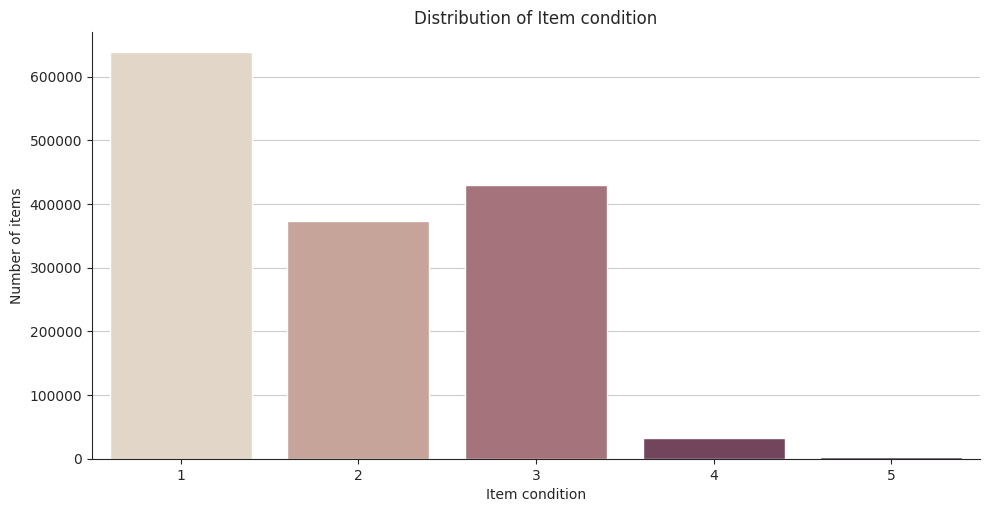

In [16]:
palette = "ch:.25"
sns.set_style("ticks",{'axes.grid' : True})

g = sns.catplot(data=dataset, x="item_condition_id", kind="count", palette=palette, aspect=2)
g.set(title = "Distribution of Item condition", xlabel="Item condition", ylabel="Number of items")

g.savefig("images/item_cond_dist.jpg", dpi=1000)
plt.show()


### Analysis of Category name

Categories are represented as textual data of the kind "MacroCategory/SubCategory1/SubCategory2/...". Each item may have a different number of subcategories. First of all, it is necessary to split them and count how many categories each item has.

In [17]:
print("Number of categories related to number of items:")
dataset["category_name"].apply(lambda x: len(x.split("/"))).value_counts()

Number of categories related to number of items:


3    1470962
5       3055
4       1330
Name: category_name, dtype: int64

A dataset containing first, second and third category of each item and some distribution analysis is performed on it.

In [18]:
categories = pd.DataFrame()
categories["first"] = dataset["category_name"].apply(lambda x: x.split("/")[0]).astype("category")
categories["second"] = dataset["category_name"].apply(lambda x: x.split("/")[1]).astype("category")
categories["third"] = dataset["category_name"].apply(lambda x: x.split("/")[2]).astype("category")

In [19]:
categories.head()

,first,second,third
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces


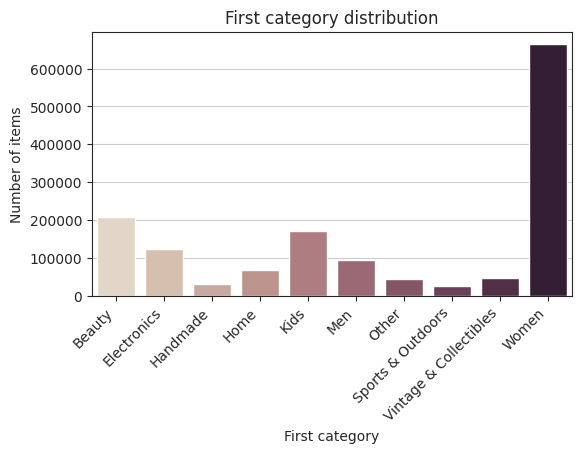

In [20]:
g = sns.countplot(categories, x="first", palette=palette)
g.set(title="First category distribution", xlabel="First category", ylabel="Number of items")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.subplots_adjust(bottom=0.33, left=0.15)
g.figure.savefig("images/first_cat_dist.jpg", dpi=1000)

plt.show()

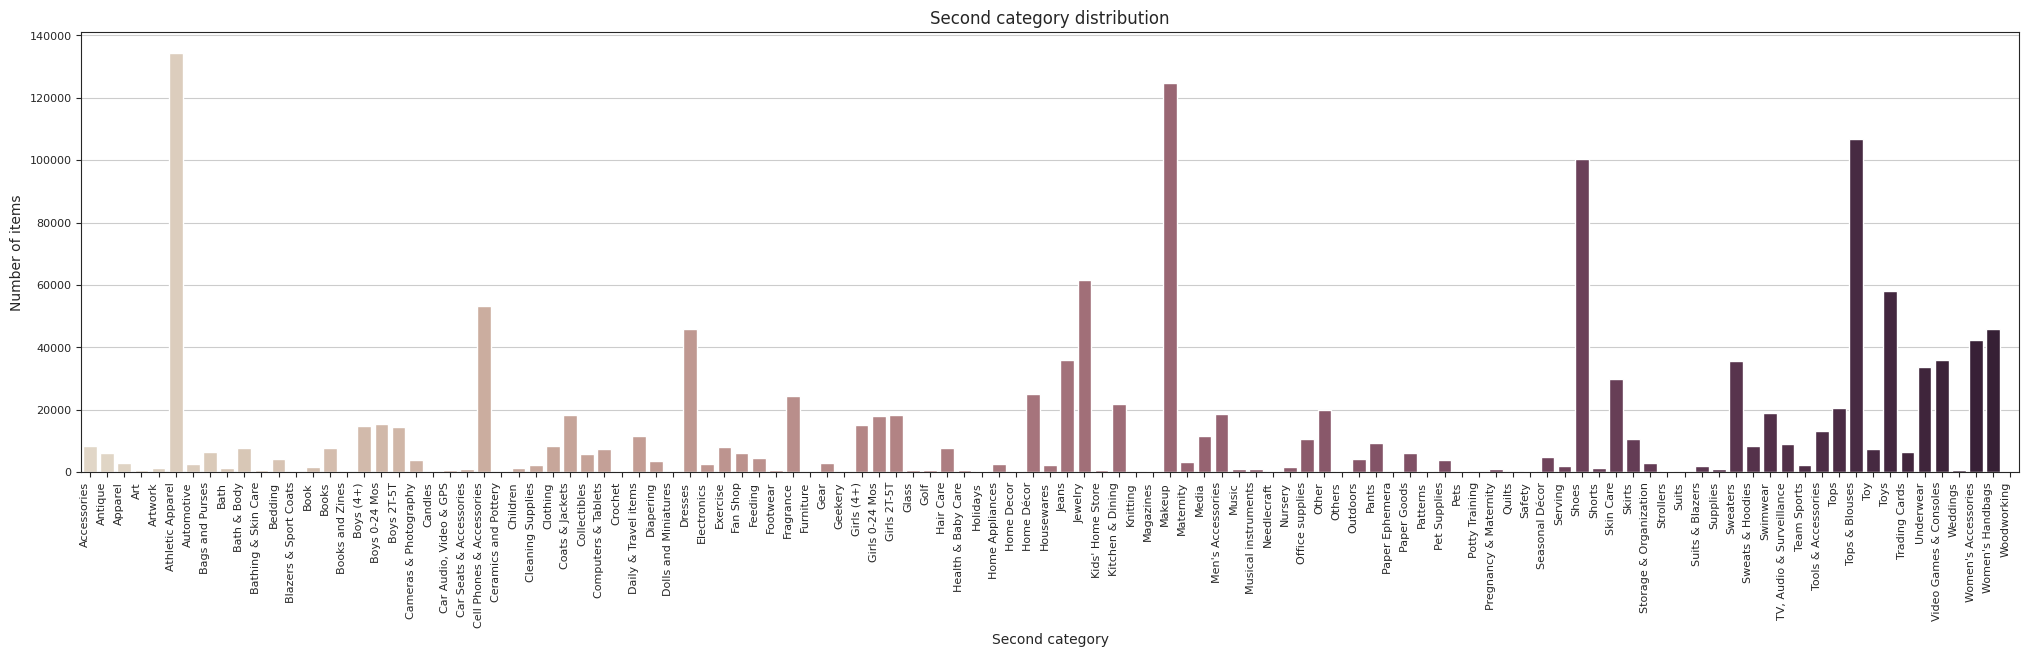

In [21]:
fig, ax = plt.subplots(figsize=(25, 8))
g = sns.countplot(categories, x="second", palette=palette, ax=ax)
g.set(title="Second category distribution", xlabel="Second category", ylabel="Number of items")
g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment='right')
g.tick_params(labelsize=8)

plt.subplots_adjust(bottom=0.33)
g.figure.savefig("images/second_cat_dist.jpg", dpi=1000)

plt.show()

The following function computes some statistics on a category and print them. It is applied to first, second and third categories.

In [22]:
def category_stats(categories):
    counts = categories.value_counts()
    print(f"Number of categories: {len(counts)}")

    min_ind = np.argmin(counts)
    print(f"Rarest category is \"{counts.index[min_ind]}\" with {counts[min_ind]} occurencies")

    max_ind = np.argmax(counts)
    print(f"Most common category is \"{counts.index[max_ind]}\" with {counts[max_ind]} occurencies")

    mean_occ = int( np.round(sum(counts) / len(counts)) )
    print(f"Mean occurencies per category is {mean_occ}")

In [23]:
categories["first"].value_counts()

Women                     663990
Beauty                    207725
Kids                      171555
Electronics               122632
Men                        93609
Home                       67831
Vintage & Collectibles     46519
Other                      45329
Handmade                   30835
Sports & Outdoors          25322
Name: first, dtype: int64

In [24]:
category_stats(categories["first"])

Number of categories: 10
Rarest category is "Sports & Outdoors" with 25322 occurencies
Most common category is "Women" with 663990 occurencies
Mean occurencies per category is 147535


In [25]:
category_stats(categories["second"])

Number of categories: 113
Rarest category is "Quilts" with 31 occurencies
Most common category is "Athletic Apparel" with 134321 occurencies
Mean occurencies per category is 13056


In [26]:
category_stats(categories["third"])

Number of categories: 870
Rarest category is "St Patricks" with 1 occurencies
Most common category is "Pants, Tights, Leggings" with 60152 occurencies
Mean occurencies per category is 1696


Some categories in the third level have a very low support for inference. For this reason, this category is not treated as categorical data.

In [27]:
counts = categories["third"].value_counts()
print(f"Less than 50 occurencies in {(counts < 50).sum()} categories")
print(f"Less than 10 occurencies in {(counts < 10).sum()} categories")

Less than 50 occurencies in 339 categories
Less than 10 occurencies in 174 categories


### Analysis of Brand name

Even worse than the third category, the brand name cannot be considered a categorical data since it has a lot of different values and each value interests only a small number of instances. Also, as seen before, almost half of the instances have a missing value here.

In [26]:
counts = dataset["brand_name"].value_counts()
len(counts)

4790

In [27]:
mean_occ = int( np.round(sum(counts) / len(counts)) )
print(f"Mean occurencies per brand is {mean_occ}")

Mean occurencies per brand is 308


In [28]:
print(f"Less than 50 occurencies in {(counts < 50).sum()} brand names")
print(f"Less than 10 occurencies in {(counts < 10).sum()} brand names")

Less than 50 occurencies in 3978 brand names
Less than 10 occurencies in 3041 brand names


### Analysis of Shipping

The shipping column is quite balanced.

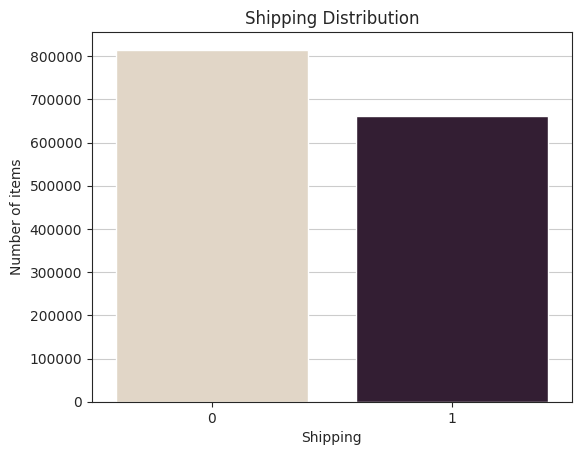

In [29]:
g = sns.countplot(dataset, x="shipping",  palette=palette)
g.set(title="Shipping Distribution", xlabel="Shipping", ylabel="Number of items")

plt.subplots_adjust(left=0.15)
g.figure.savefig("images/shipping_dist.jpg", dpi=1000)

plt.show()

### Analysis of Price

A distribution plot of the price is shown: the prices are mostly concentrated below 50$, but there are some outliers ranging up to 2000$.

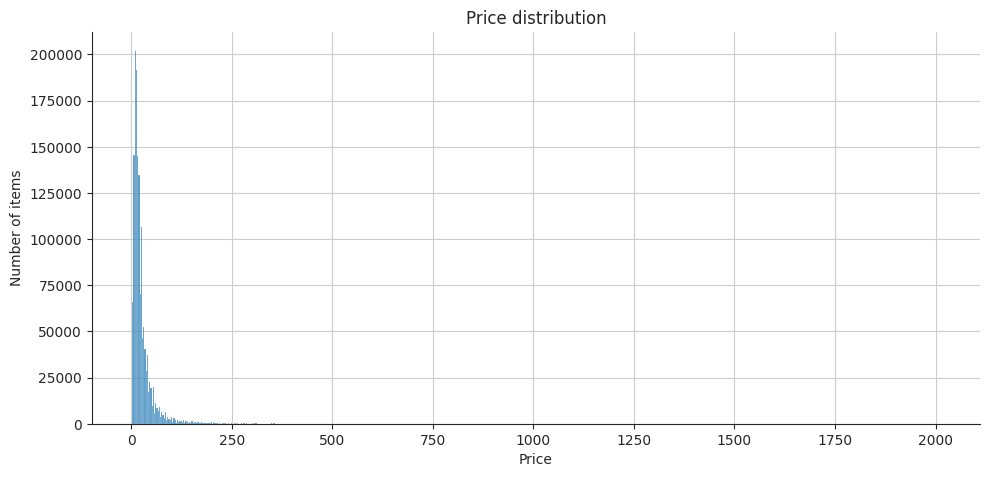

In [34]:
g = sns.displot(data=dataset, x="price", binwidth=3, height=5, aspect=2)
g.set(title="Price distribution", xlabel="Price", ylabel="Number of items")
plt.subplots_adjust(top=0.9)
g.figure.savefig("images/price_dist.jpg", dpi=1000)

plt.show()


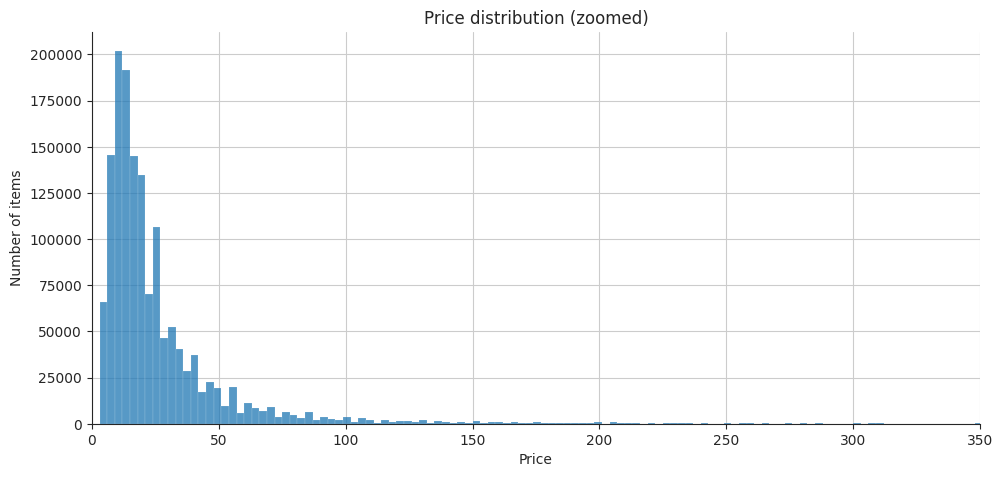

In [35]:
g = sns.displot(data=dataset, x="price", binwidth=3, height=5, aspect=2)
g.set(title="Price distribution (zoomed)", xlabel="Price", ylabel="Number of items")
plt.xlim(0, 350)
plt.subplots_adjust(top=0.9)
g.figure.savefig("images/price_dist_zoomed.jpg", dpi=1000)

plt.show()

### Analysis of textual data

All the textual data is grouped into one single column. This is because a bag-of-words approach will be used, without making a specific distinction between name, brand name and item description, also because of the missing values in some of these columns. By conducting some experiments, it has been found that considering all these columns together leads to a better performance. Also, the text describing the third category is added to this text field: for the meaningful categories (those with a considerable number of instances) this text could become an important keyword used by the model.

In [13]:
dataset["text"] = (dataset["name"] + " " + 
                    dataset["brand_name"] + " " +
                    categories["third"].apply(lambda c: c.lower()) + " " + 
                    dataset["item_description"])

In [14]:
dataset = dataset.drop(["name", "category_name", "brand_name", "item_description"], axis=1)

A PoS (Part of Speech) tagging of the words contained in the text is performed using a NLP library. First, just for illustrative purposes, this is applied to a subset of the instances and some wordcloud for different categories of tag are created:

In [6]:
tagged_text = dataset["text"][0:10000].apply(nlp)

/tmp/ipykernel_8129/4267953173.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tagged_text = dataset["text"][0:10000].apply(nlp)


In [19]:
def get_typed_corpus(tagged, tag_type):
    res = ""
    for i, tagged_sentence in tagged.items():
        for token in tagged_sentence:
            if token.pos_ == tag_type:
                res = res + token.text + " "

    return res

def tag_wordcloud(tagged, tag_type):
    corpus = ""
    for i, tagged_sentence in tagged.items():
        for token in tagged_sentence:
            if token.pos_ == tag_type:
                corpus = corpus + token.text + " "

    wc = WordCloud(height=1000, width=1000, background_color ='white', min_font_size = 10).generate(corpus)
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

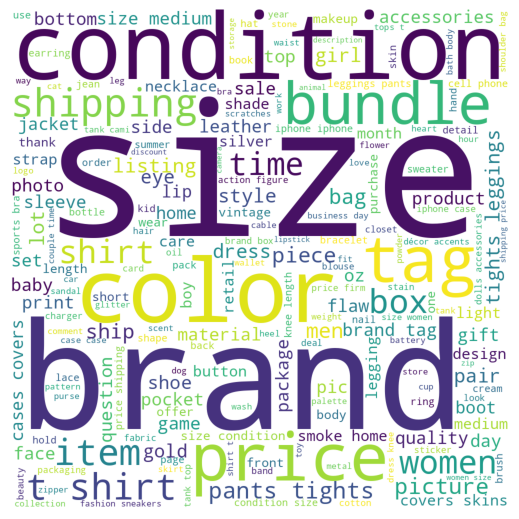

In [20]:
tag_wordcloud(tagged_text, "NOUN")

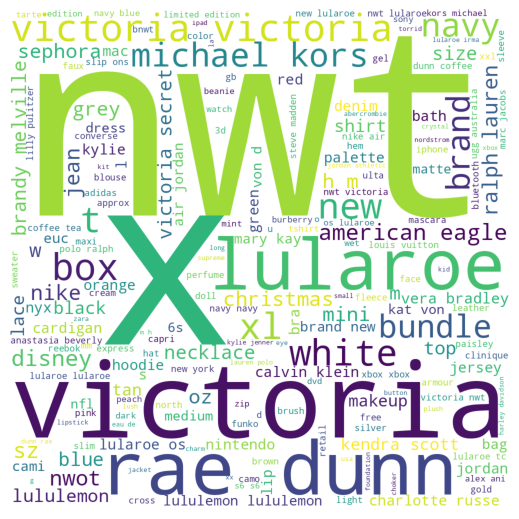

In [23]:
tag_wordcloud(tagged_text, "PROPN")

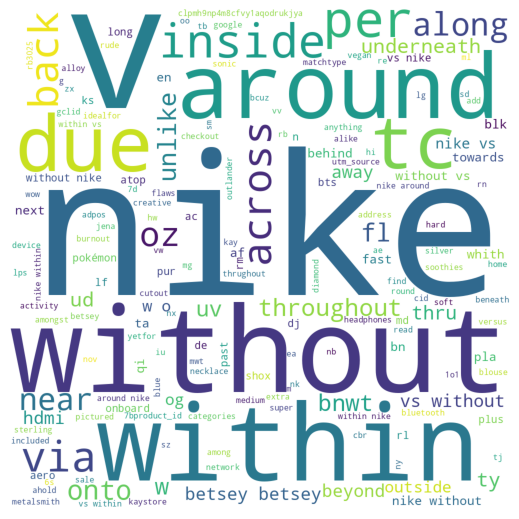

In [24]:
tag_wordcloud(tagged_text, "ADP")

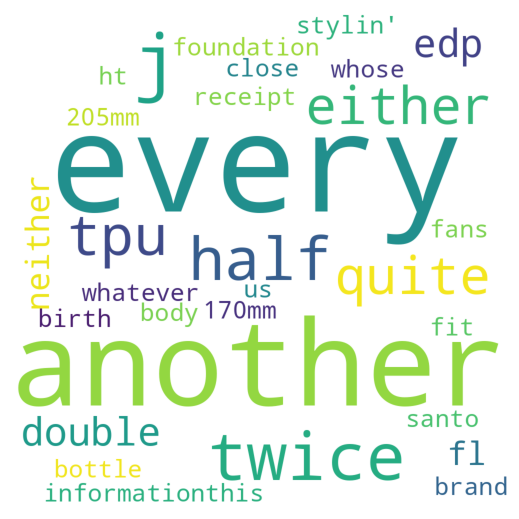

In [25]:
tag_wordcloud(tagged_text, "DET")

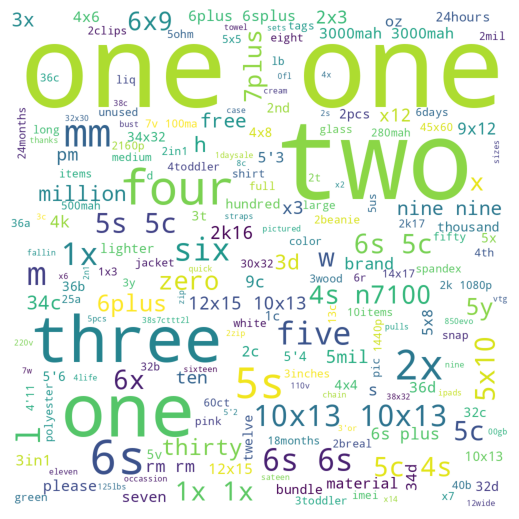

In [26]:
tag_wordcloud(tagged_text, "NUM")

### Encoding of categorical data

Item condition ID is one-hot encoded:

In [15]:
dataset = OneHotEncoder(cols=["item_condition_id"]).fit(dataset).transform(dataset)

/home/fregonesi/.conda/envs/project_aml/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


The first two categories in the hierarchy are binary encoded:

In [16]:
dataset["first_cat"] = categories["first"]
dataset["second_cat"] = categories["second"]

dataset = BinaryEncoder(cols=["first_cat", "second_cat"]).fit(dataset).transform(dataset)

### Text cleaning

All the tokens (words) in the text column are PoS-tagged, then not useful tokens (e.g. punctuations, spaces) are removed, and all remaining tokens and lemmatized.

In [8]:
allowed = set(['ADJ', 'ADV', 'NOUN', 'PROPN', 'NUM', 'VERB', 'AUX', 'ADP', 'CONJ', 'CCONJ',
    'DET', 'INTJ', 'PART', 'PRON', 'SCONJ'])

def lemmatize_sentence(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc if token.pos_ in allowed])

def lemmatize_series(s):
    return s.apply(lemmatize_sentence)

In [10]:
dataset["text"] = parallelize_on_series(dataset["text"], lemmatize_series)

### Split in train, validation and test set

Dataset is split in train, validation and test sets by stratifying on the combination of first and second category. 30% of the data is used for the test set, whereas the remaining data is divided in 80% for training and 20% for validation.

In [19]:
dataset["first_second_cat"] = categories["first"].combine(categories["second"], lambda x,y: f"{x}/{y}")
X, X_test, Y, Y_test = train_test_split(dataset.drop("price", axis=1), dataset["price"], test_size=0.3, stratify=dataset["first_second_cat"], shuffle=True)

In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=X["first_second_cat"], shuffle=True)

In [21]:
def clean(df):
    df = df.drop("first_second_cat", axis=1)
    df.reset_index(drop=True, inplace=True)
    return df

X_train = clean(X_train)
X_val = clean(X_val)
X_test = clean(X_test)
Y_train.reset_index(drop=True, inplace=True)
Y_val.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

### Text vectorization

Text is vectorized by fitting a TfIdf vectorizer on the training data and then applying it to train, validation and test set

In [24]:
vectorizer = TfidfVectorizer(
    max_features = 10000,
    min_df=50, # min occurencies that a word must have
    max_df=0.8, # words that occur in more than 80% of documents are discarded
    analyzer="word", # single "n-grams" are words
    norm = "l2",
    ngram_range=(1,2), # consider 1-gram and bigrams (one or two words for each token)
    stop_words = None, # stop words were already cleaned in previous steps
    dtype=np.float32 # output type
)

vectorized_train_text = vectorizer.fit_transform(X_train["text"])
vectorized_val_text = vectorizer.transform(X_val["text"])
vectorized_test_text = vectorizer.transform(X_test["text"])

The vectorized text features are joined with the dataset

In [27]:
n_features = vectorized_train_text.shape[1]
features_names = [f"text_{i}" for i in range(n_features)]

def add_vectorized_text_to_dataset(df, vectorized_text):
    text_df = pd.DataFrame.sparse.from_spmatrix(vectorized_text)
    text_df = text_df.set_axis(features_names, axis=1, copy=True)

    df = pd.concat([df, text_df], axis=1)
    df = df.drop("text", axis = 1)

    df.reset_index(drop=True, inplace=True)

    return df

X_train = add_vectorized_text_to_dataset(X_train, vectorized_train_text)
X_val = add_vectorized_text_to_dataset(X_val, vectorized_val_text)
X_test = add_vectorized_text_to_dataset(X_test, vectorized_test_text)

### Save preprocessed data

Since the preprocessing steps are computationally intensive and require some time, it is wise to save the data for later usage

In [ ]:
folder = "preprocessed_data/"

X_train.to_pickle(folder + "X_train.obj")
X_val.to_pickle(folder + "X_val.obj")
X_test.to_pickle(folder + "X_test.obj")
Y_train.to_pickle(folder + "Y_train.obj")
Y_val.to_pickle(folder + "Y_val.obj")
Y_test.to_pickle(folder + "Y_test.obj")

## Model training

Eventually load the preprocessed data from memory

In [3]:
folder = "preprocessed_data/"

X_train = pd.read_pickle(folder + "X_train.obj").astype(pd.SparseDtype("float32", 0))
X_val = pd.read_pickle(folder + "X_val.obj").astype(pd.SparseDtype("float32", 0))
X_test = pd.read_pickle(folder + "X_test.obj").astype(pd.SparseDtype("float32", 0))
Y_train = pd.read_pickle(folder + "Y_train.obj").astype("float32")
Y_val = pd.read_pickle(folder + "Y_val.obj").astype("float32")
Y_test = pd.read_pickle(folder + "Y_test.obj").astype("float32")

First, a new function is defined. Such function creates a new generator for the given dataset and labels and with the specified batch size. It is necessary to use a generator during training since the whole dataset cannot fit into the memory.

In [8]:
def get_batch_generator(features, labels, batch_size):
    def generator():
        first_ind = 0
        second_ind = batch_size
        while True:
            if second_ind <= len(features):
                yield((features[first_ind:second_ind], labels.iloc[first_ind:second_ind]))
                first_ind += batch_size
                second_ind += batch_size
            else: # the last batch is smaller so it is built repeating the first elements in order to get uniform size
                trailing_num = len(features) - first_ind
                beginning_num = batch_size - trailing_num

                batch_features = features[first_ind:len(features)]
                batch_features = pd.concat([batch_features, features[0:beginning_num]])

                batch_labels = labels.iloc[first_ind:len(features)]
                batch_labels = pd.concat([batch_labels, labels.iloc[0:beginning_num]])

                yield (batch_features, batch_labels)

                # restart from beginning
                first_ind = 0
                second_ind = batch_size

    return generator

Then, a model is defined

In [25]:
cherrypicked_seed = 42

# declaration of model "Deep 1"

model = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dropout(0.2, seed=cherrypicked_seed),

    Dense(512, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(512, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(128, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(128, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(64, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(32, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(16, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(8, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.2, seed=cherrypicked_seed),
    Dense(1, activation="linear")
])

model.compile(optimizer="adam", loss="mse", metrics=["mse", "mape", "mae", "msle"])
model.summary()

fBestModel = 'best_model.h5'
early_stop = EarlyStopping(monitor='val_mse', mode="min", patience=5, min_delta = 0.01, verbose=1, restore_best_weights=True)
best_model = ModelCheckpoint(fBestModel, verbose=1, save_best_only=True, monitor='val_mse', mode="min")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_22 (Dropout)        (None, 10017)             0         
                                                                 
 dense_22 (Dense)            (None, 512)               5129216   
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dropout_25 (Dropout)        (None, 256)              

Then the model is trained using the generator

In [ ]:
batch_size = 2048
n_features = X_train.shape[1]

history = model.fit(
  # generator for (X, y) pairs for training data
  tf.data.Dataset.from_generator(
    get_batch_generator(X_train, Y_train, batch_size), 
    output_signature=(
        tf.TensorSpec(shape=(batch_size, n_features), dtype=tf.float32), 
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float64)
    )
  ),
  # generator for (X, y) pairs for validation data
  validation_data = tf.data.Dataset.from_generator(
    get_batch_generator(X_val, Y_val, batch_size),  
    output_signature=(
        tf.TensorSpec(shape=(batch_size, n_features), dtype=tf.float32), 
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float64)
    )
  ),
  epochs=1000, # maximum number, it will finish sooner thanks to early stopping
  batch_size=batch_size,
  callbacks = [best_model, early_stop],
  verbose = 1,
  use_multiprocessing = True,
  workers = 12,
  steps_per_epoch = int( np.ceil(X_train.shape[0] / batch_size) ),
  validation_steps = int( np.ceil(X_val.shape[0] / batch_size) ),
)
history = history.history

It is possible to save the model history for later analysis

In [9]:
pd.DataFrame.from_dict(history).to_pickle("histories/deep1.obj")

### Training history plots

Read the history of one of the models in order to perform analysis on it:

In [13]:
history = pd.read_pickle("histories/deep7.obj")

Function for plotting the training history on different metrics on training and validation sets:

In [10]:
def plot_history(history, name):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    g = sns.lineplot(data=history[["loss", "val_loss"]], ax=axes[0, 0])
    g.set(xlabel="Epochs", ylabel="Loss")
    g = sns.lineplot(data=history[["mse", "val_mse"]], ax=axes[0, 1])
    g.set(xlabel="Epochs", ylabel="MSE")
    g = sns.lineplot(data=history[["msle", "val_msle"]], ax=axes[0, 2])
    g.set(xlabel="Epochs", ylabel="MSLE")
    g = sns.lineplot(data=history[["mape", "val_mape"]], ax=axes[1, 0])
    g.set(xlabel="Epochs", ylabel="MAPE")
    g = sns.lineplot(data=history[["mae", "val_mae"]], ax=axes[1, 1])
    g.set(xlabel="Epochs", ylabel="MAE")

    axes[1, 2].axis("off")
    fig.suptitle(f"Training metrics for model {name}")
    fig.savefig(f"images/training_history_{name}.jpeg", dpi=1000)

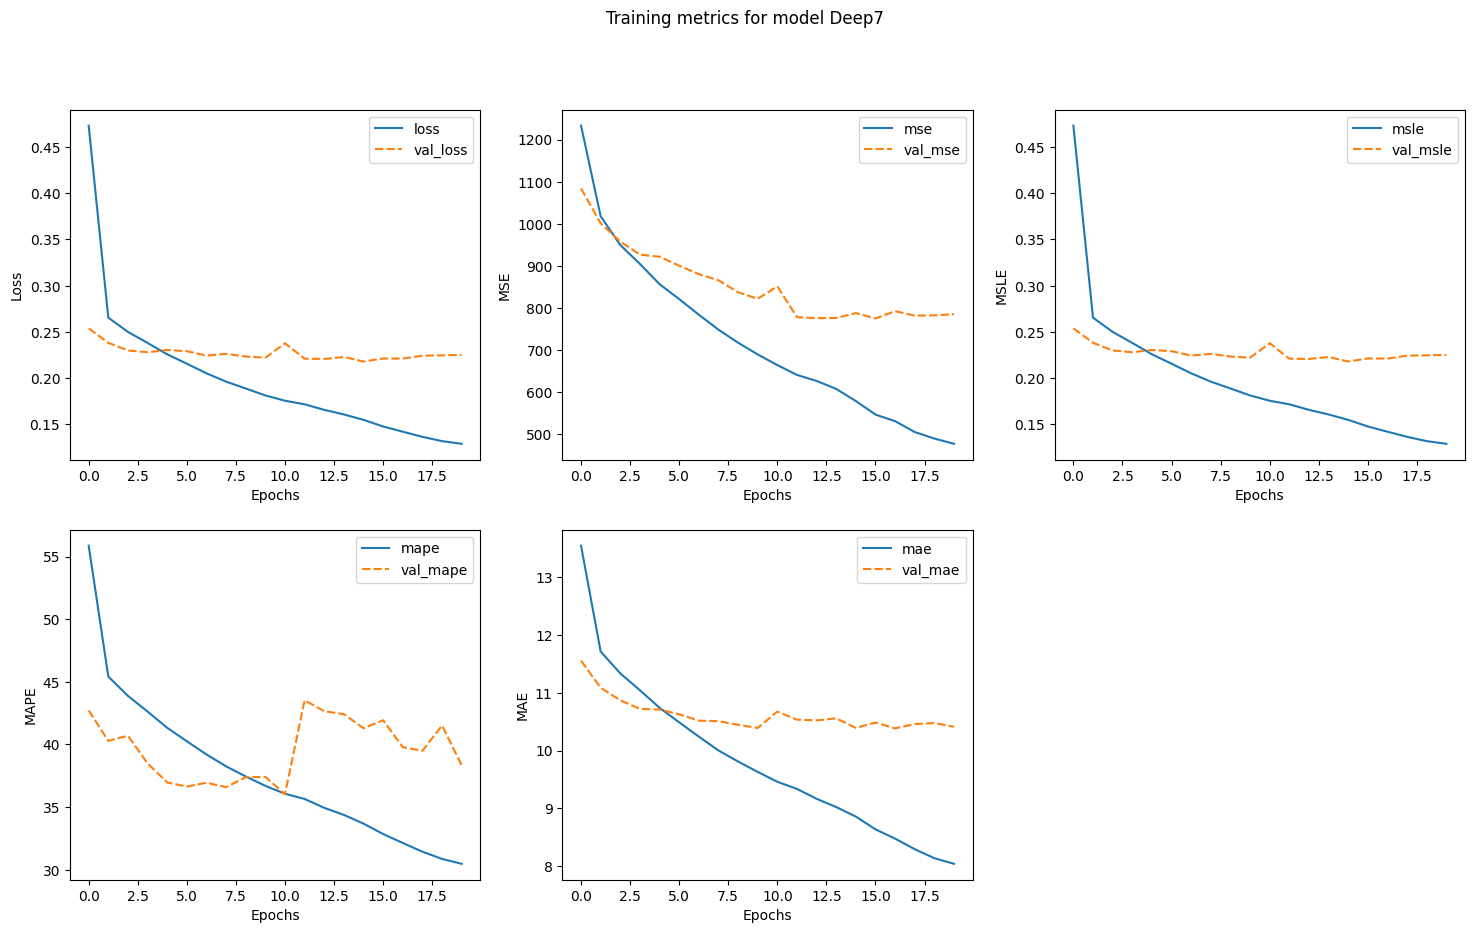

In [14]:
plot_history(history, "Deep7")

## Evaluation

The model is loaded into memory (if not already present)

In [37]:
model = keras.models.load_model("shallow_6.h5")
model_name = "Shallow 6"

Predictions are performed in batches in order to avoid memory issues:

In [6]:
def batch_predict(df, model, batch_size=4096):
    predictions = np.empty((0, 1))
    iterations = len(df) // batch_size + 1
    for i in range(0, iterations):
        chunk = df[i*batch_size:(i+1)*batch_size]
        chunk = np.asarray(chunk).astype(np.float32)
        partial = model.predict(chunk, verbose=False)
        predictions = np.vstack((predictions, partial))
        print(f"Iteration {i + 1}/{iterations}")

    return predictions

In [38]:
predictions = batch_predict(X_test, model)

/tmp/ipykernel_5931/4033549557.py:6: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  chunk = np.asarray(chunk).astype(np.float32)


Iteration 1/109
Iteration 2/109
Iteration 3/109
Iteration 4/109
Iteration 5/109
Iteration 6/109
Iteration 7/109
Iteration 8/109
Iteration 9/109
Iteration 10/109
Iteration 11/109
Iteration 12/109
Iteration 13/109
Iteration 14/109
Iteration 15/109
Iteration 16/109
Iteration 17/109
Iteration 18/109
Iteration 19/109
Iteration 20/109
Iteration 21/109
Iteration 22/109
Iteration 23/109
Iteration 24/109
Iteration 25/109
Iteration 26/109
Iteration 27/109
Iteration 28/109
Iteration 29/109
Iteration 30/109
Iteration 31/109
Iteration 32/109
Iteration 33/109
Iteration 34/109
Iteration 35/109
Iteration 36/109
Iteration 37/109
Iteration 38/109
Iteration 39/109
Iteration 40/109
Iteration 41/109
Iteration 42/109
Iteration 43/109
Iteration 44/109
Iteration 45/109
Iteration 46/109
Iteration 47/109
Iteration 48/109
Iteration 49/109
Iteration 50/109
Iteration 51/109
Iteration 52/109
Iteration 53/109
Iteration 54/109
Iteration 55/109
Iteration 56/109
Iteration 57/109
Iteration 58/109
Iteration 59/109
Iterat

Finally all the metrics are computed

In [6]:
test_mse = mean_squared_error(Y_test, predictions)
test_msle = mean_squared_log_error(Y_test, predictions)
test_mape = mean_absolute_percentage_error(Y_test, predictions)
test_mae = mean_absolute_error(Y_test, predictions)

test_metrics = {
    "MSE": test_mse,
    "MSLE": test_msle,
    "MAPE": test_mape,
    "MAE": test_mae
}

print(test_metrics)

{'MSE': 710.8397433712328, 'MSLE': 0.27974657524555496, 'MAPE': 0.5686486962830201, 'MAE': 11.27100974344407}


Absolute and relative errors are plotted using a logscale on the y axis.

In [39]:
predictions = predictions.reshape((len(predictions)))

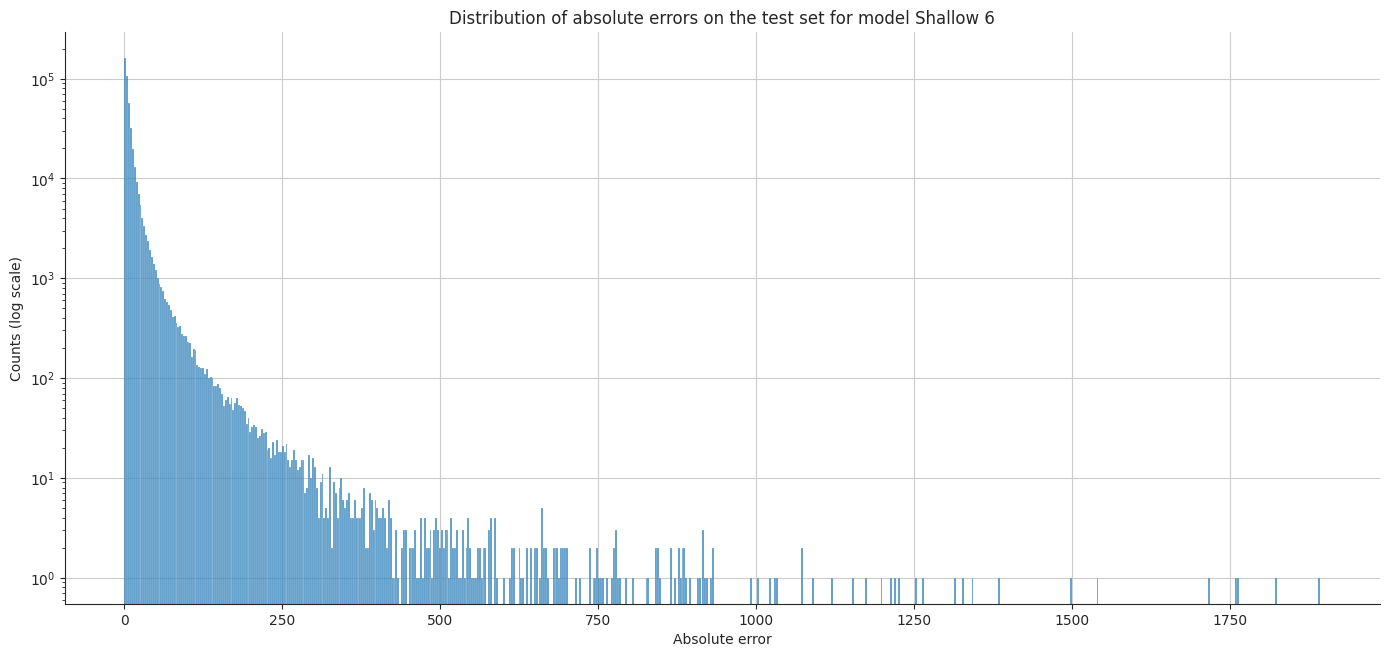

In [40]:
absolute_errors = abs(predictions - Y_test)

sns.set_style("ticks",{'axes.grid' : True})

g = sns.displot(absolute_errors, binwidth=3, height=7, aspect=2, log_scale=(False, 10))
g.set(title=f"Distribution of absolute errors on the test set for model {model_name}", xlabel="Absolute error", ylabel="Counts (log scale)")
plt.subplots_adjust(top=0.9)
g.figure.savefig(f"images/abs_error_{model_name}.jpeg", dpi=1000)

plt.show()

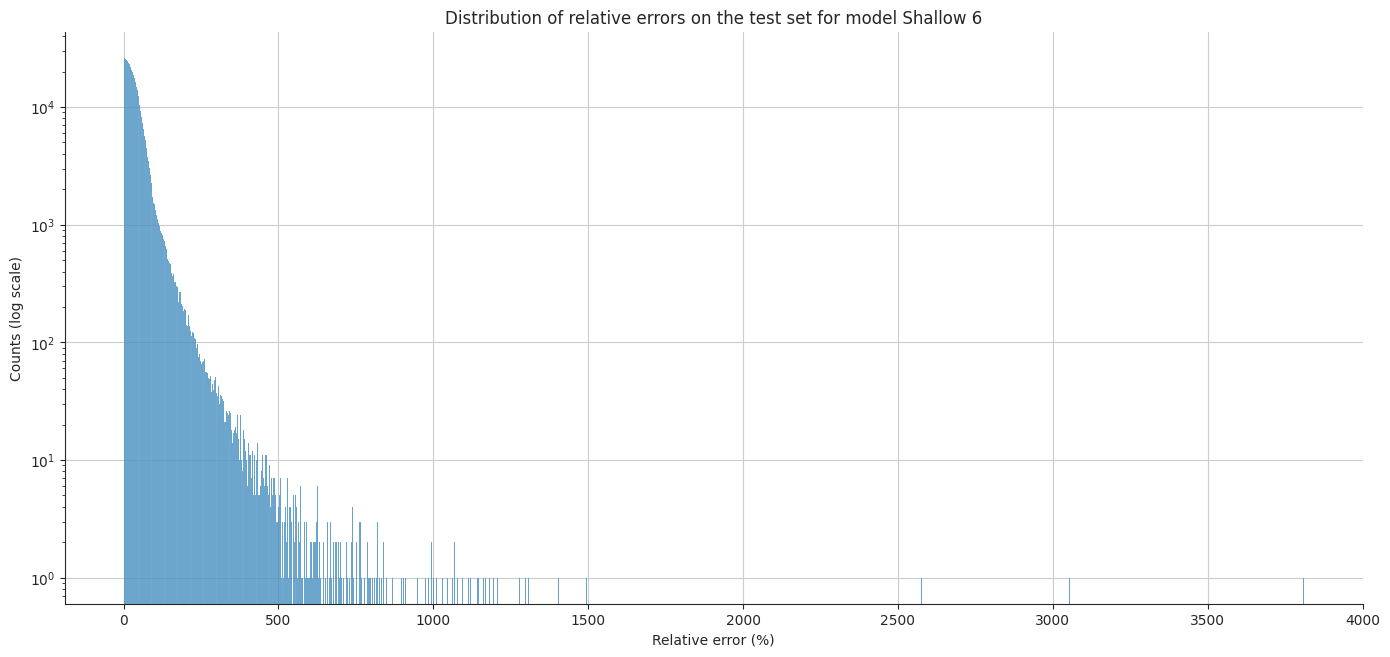

In [41]:
relative_errors = (absolute_errors / Y_test) * 100
g = sns.displot(relative_errors, binwidth=3, height=7, aspect=2, log_scale=(False, 10))
g.set(title=f"Distribution of relative errors on the test set for model {model_name}", xlabel="Relative error (%)", ylabel="Counts (log scale)")
plt.subplots_adjust(top=0.9)
g.figure.savefig(f"images/rel_error_{model_name}.jpeg", dpi=1000)

plt.show()

A zoomed plot of the relative error (only for instances with error lower than 100%) is shown.

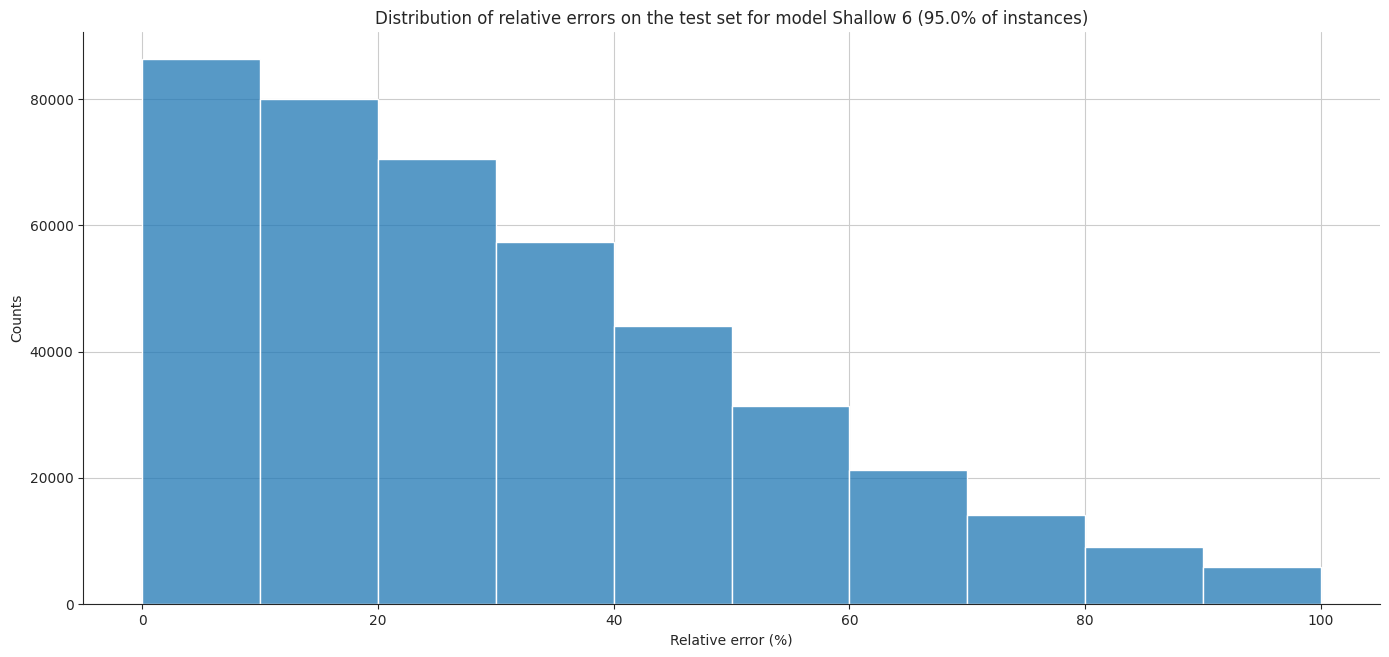

In [42]:
relative_errors = (absolute_errors / Y_test) * 100
coverage = np.round(((relative_errors < 100).sum() / len(Y_test)) * 100)
g = sns.displot(relative_errors, bins=[x * 10 for x in range(0,11)], height=7, aspect=2)
g.set(title=f"Distribution of relative errors on the test set for model {model_name} ({coverage}% of instances)", xlabel="Relative error (%)", ylabel="Counts")
plt.subplots_adjust(top=0.9)
g.figure.savefig(f"images/zoomed_rel_error_{model_name}.jpeg", dpi=1000)

plt.show()

## Best models

This section simply contains the definition of the models which performed better in our experiments.

### Best shallow model

In [5]:
cherrypicked_seed = 42

best_shallow = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dropout(0.2, seed=cherrypicked_seed),

    Dense(2048, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.5, seed=cherrypicked_seed),

    Dense(1024, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.5, seed=cherrypicked_seed),

    Dense(512, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.5, seed=cherrypicked_seed),

    Dense(1, activation="linear")
])

best_shallow.compile(optimizer="adam", loss="msle", metrics=["mse", "mape", "mae", "msle"])
best_shallow.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 10017)             0         
                                                                 
 dense (Dense)               (None, 2048)              20516864  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0

2023-01-26 12:46:38.774684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Best base model

In [6]:
cherrypicked_seed = 42

best_base = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dropout(0.2, seed=cherrypicked_seed),

    Dense(1024, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.2, seed=cherrypicked_seed),

    Dense(512, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.2, seed=cherrypicked_seed),

    Dense(256, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.2, seed=cherrypicked_seed),

    Dense(128, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.1, seed=cherrypicked_seed),

    Dense(64, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.1, seed=cherrypicked_seed),

    Dense(32, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.1, seed=cherrypicked_seed),

    Dense(16, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.1, seed=cherrypicked_seed),

    Dense(4, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.1, seed=cherrypicked_seed),

    Dense(1, activation="linear")
])

best_base.compile(optimizer="adam", loss="msle", metrics=["mse", "mape", "mae", "msle"])
best_base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 10017)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              10258432  
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)              

### Best deep model

In [7]:
cherrypicked_seed = 42

best_deep = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dropout(0.2, seed=cherrypicked_seed),

    Dense(512, activation=LeakyReLU(alpha=0.2)),

    Dense(512, activation=LeakyReLU(alpha=0.2)),

    Dense(256, activation=LeakyReLU(alpha=0.2)),

    Dense(256, activation=LeakyReLU(alpha=0.2)),

    Dense(128, activation=LeakyReLU(alpha=0.2)),

    Dense(128, activation=LeakyReLU(alpha=0.2)),

    Dense(64, activation=LeakyReLU(alpha=0.2)),

    Dense(32, activation=LeakyReLU(alpha=0.2)),

    Dense(16, activation=LeakyReLU(alpha=0.2)),

    Dense(8, activation=LeakyReLU(alpha=0.2)),

    Dense(1, activation="linear")
])

best_deep.compile(optimizer="adam", loss="msle", metrics=["mse", "mape", "mae", "msle"])
best_deep.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_13 (Dropout)        (None, 10017)             0         
                                                                 
 dense_13 (Dense)            (None, 512)               5129216   
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 128)              